In [1]:
!pip install -q mlflow scikit-learn pandas matplotlib seaborn nltk boto3 dagshub


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.7/24.7 MB 93.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 95.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.0/261.0 kB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 114.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.2/85.2 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 733.8/733.8 kB 40.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
# Test mlflow

import mlflow
import dagshub

dagshub.init(repo_owner='djnold', repo_name='mlops-project', mlflow=True)

# mlflow.set_tracking_uri("http://ec2-52-207-204-137.compute-1.amazonaws.com:5000/")

with mlflow.start_run():
    mlflow.log_param("param1", 15)
    mlflow.log_metric("metric1", 0.89)

❗❗❗ AUTHORIZATION REQUIRED ❗❗❗

Output()



Open the following link in your browser to authorize the client:
https://dagshub.com/login/oauth/authorize?state=11d8a710-f4cb-484e-8a87-4570839808c9&client_id=32b60ba385aa7cecf24046d8195a71c07dd345d9657977863b52e7748e0f0f28&middleman_request_id=7de9acaeb023f7e023020ddad15a6a5411f2b5e8b04aaae1d1c2ccae58ba4751




Accessing as djnold

Initialized MLflow to track repo "djnold/mlops-project"

Repository djnold/mlops-project initialized!

🏃 View run monumental-deer-645 at: https://dagshub.com/djnold/mlops-project.mlflow/#/experiments/0/runs/c8c5d7f9fc824245887427d2a0dcb058
🧪 View experiment at: https://dagshub.com/djnold/mlops-project.mlflow/#/experiments/0


In [4]:
# Create baseline model

import numpy as np
import pandas as pd

In [5]:
df = pd.read_csv('/content/Combined Data.csv')
df.head()

,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety


In [6]:
df.dropna(inplace=True)

In [7]:
df.drop_duplicates(inplace=True)

In [8]:
df = df.rename(columns={'status': 'sentiment'})

In [9]:
df = df.drop(columns=['Unnamed: 0'])

df.head()

,statement,sentiment
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,I've shifted my focus to something else but I'...,Anxiety
4,"I'm restless and restless, it's been a month n...",Anxiety


In [10]:
df['sentiment'].value_counts()

,count
sentiment,
Normal,16343
Depression,15404
Suicidal,10652
Anxiety,3841
Bipolar,2777
Stress,2587
Personality disorder,1077


In [11]:
x = df['sentiment'].isin(['Normal', 'Depression', 'Suicidal'])

df = df[x]

In [12]:
df.head()

,statement,sentiment
733,"Gr gr dreaming of ex crush to be my game, God",Normal
734,wkwkwk what a joke,Normal
735,Leaves are also standby in front of the PC ......,Normal
736,Thank God even though it's just a ride through,Normal
737,wedding teaser concept using the song day6 - o...,Normal


In [13]:
df = df[~(df['statement'].str.strip() == '')]

In [14]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [15]:
# Ensure necessary NLTK data is downloaded
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [16]:
# Define the preprocessing function
def preprocess_statement(statement):
    # Convert to lowercase
    statement = statement.lower()

    # Remove trailing and leading whitespaces
    statement = statement.strip()

    # Remove newline characters
    statement = re.sub(r'\n', ' ', statement)

    # Remove non-alphanumeric characters, except punctuation
    statement = re.sub(r'[^A-Za-z0-9\s!?.,]', '', statement)

    # Remove stopwords but retain important ones for sentiment analysis
    stop_words = set(stopwords.words('english')) - {'not', 'but', 'however', 'no', 'yet'}
    statement = ' '.join([word for word in statement.split() if word not in stop_words])

    # Lemmatize the words
    lemmatizer = WordNetLemmatizer()
    statement = ' '.join([lemmatizer.lemmatize(word) for word in statement.split()])

    return statement

In [17]:
# Apply the preprocessing function to the 'statement' column
df['statement'] = df['statement'].apply(preprocess_statement)

In [18]:
df['sentiment'] = df['sentiment'].replace({'Depression':-1, 'Normal':0, 'Suicidal':1})

/tmp/ipython-input-18-3389262563.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['sentiment'] = df['sentiment'].replace({'Depression':-1, 'Normal':0, 'Suicidal':1})


In [19]:
df.head()

,statement,sentiment
733,"gr gr dreaming ex crush game, god",0
734,wkwkwk joke,0
735,leaf also standby front pc ... office no longe...,0
736,thank god even though ride,0
737,"wedding teaser concept using song day6 only, s...",0


In [30]:
import mlflow
import mlflow.sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_predict, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

In [21]:
# Step 1: Vectorize the comments using Bag of Words (CountVectorizer)
vectorizer = CountVectorizer(max_features=10000)  # Bag of Words model with a limit of 1000 features

In [22]:
X = vectorizer.fit_transform(df['statement']).toarray()
y = df['sentiment']  # Assuming 'sentiment' is the target variable (0 or 1 for binary classification)

In [23]:
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [24]:
X.shape

(42399, 10000)

In [25]:
y

,sentiment
733,0
734,0
735,0
736,0
737,0
...,...
48283,-1
48284,-1
48285,-1
48286,-1


In [26]:
y.shape

(42399,)

In [27]:
# Step 2: Set up the MLflow tracking server
mlflow.set_tracking_uri("https://dagshub.com/djnold/mlops-project.mlflow")

In [28]:
# Set or create an experiment
mlflow.set_experiment("RF Baseline")

<Experiment: artifact_location='mlflow-artifacts:/8d24e8f4818d49efa6d7b319ca70848f', creation_time=1751969460414, experiment_id='1', last_update_time=1751969460414, lifecycle_stage='active', name='RF Baseline', tags={}>

🏃 View run RandomForest_Baseline_TrainTestSplit at: https://dagshub.com/djnold/mlops-project.mlflow/#/experiments/1/runs/b0cbd83b59094b769b17f891a913d6f7
🧪 View experiment at: https://dagshub.com/djnold/mlops-project.mlflow/#/experiments/1
Accuracy: 0.6751179245283019
              precision    recall  f1-score   support

          -1       0.61      0.77      0.68      3081
           0       0.72      0.96      0.82      3269
           1       0.81      0.10      0.17      2130

    accuracy                           0.68      8480
   macro avg       0.72      0.61      0.56      8480
weighted avg       0.71      0.68      0.61      8480



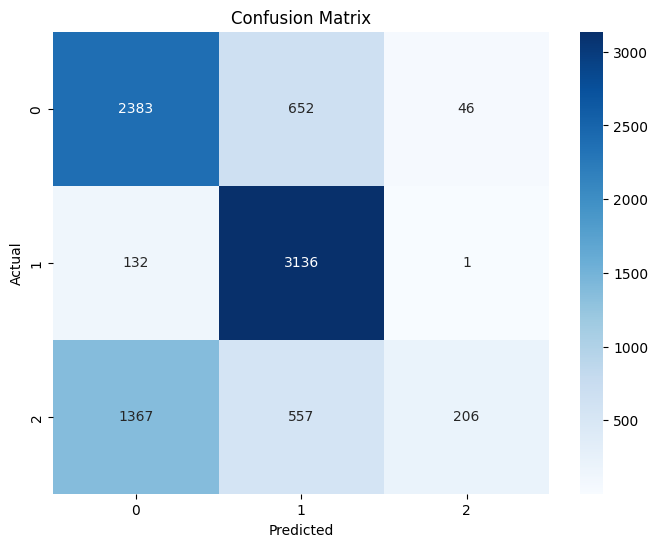

In [33]:
# Step 1: Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Step 2: Define and train a Random Forest baseline model using a simple train-test split
with mlflow.start_run() as run:
    # Log a description for the run
    mlflow.set_tag("mlflow.runName", "RandomForest_Baseline_TrainTestSplit")
    mlflow.set_tag("experiment_type", "baseline")
    mlflow.set_tag("model_type", "RandomForestClassifier")

    # Add a description
    mlflow.set_tag("description", "Baseline RandomForest model for sentiment analysis using Bag of Words (BoW) with a simple train-test split")

    # Log parameters for the vectorizer
    mlflow.log_param("vectorizer_type", "CountVectorizer")
    mlflow.log_param("vectorizer_max_features", vectorizer.max_features)

    # Log Random Forest parameters
    n_estimators = 200
    max_depth = 15

    mlflow.log_param("n_estimators", n_estimators)
    mlflow.log_param("max_depth", max_depth)

    # Initialize and train the model
    model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Log metrics for each class and accuracy
    accuracy = accuracy_score(y_test, y_pred)
    mlflow.log_metric("accuracy", accuracy)

    classification_rep = classification_report(y_test, y_pred, output_dict=True)

    for label, metrics in classification_rep.items():
        if isinstance(metrics, dict):  # For precision, recall, f1-score, etc.
            for metric, value in metrics.items():
                mlflow.log_metric(f"{label}_{metric}", value)

    # Confusion matrix plot
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")

    # Save and log the confusion matrix plot
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("/content/confusion_matrix.png")

    # Log the Random Forest model
    # mlflow.sklearn.log_model(model, "model")

    # Save model to file
    joblib.dump(model, '/content/model.joblib')

    # # Log it to DagsHub's MLflow
    # mlflow.log_artifact("model.pkl")

    # Optionally log the dataset itself (if it's small enough)
    df.to_csv("dataset.csv", index=False)
    mlflow.log_artifact("/content/dataset.csv")

    # # Save run ID to use it immediately after training
    # run_id = run.info.run_id

# Display final accuracy
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))

# # Automatically Load Model from DagsHub MLflow ====
# from mlflow.artifacts import download_artifacts

# # Set tracking URI (replace with your actual repo URL if needed)
# mlflow.set_tracking_uri("https://dagshub.com/<username>/<repo>.mlflow")

# # Download the model artifact using the same run ID
# model_path = download_artifacts(run_id=run_id, artifact_path="model.pkl")

# # Load the model
# loaded_model = joblib.load(model_path)
# print("Model reloaded from MLflow (DagsHub)")

In [34]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.61      0.77      0.68      3081
           0       0.72      0.96      0.82      3269
           1       0.81      0.10      0.17      2130

    accuracy                           0.68      8480
   macro avg       0.72      0.61      0.56      8480
weighted avg       0.71      0.68      0.61      8480



In [35]:
df.to_csv('mental_preprocessing.csv', index=False)

In [36]:
pd.read_csv('mental_preprocessing.csv').head()

,statement,sentiment
0,"gr gr dreaming ex crush game, god",0
1,wkwkwk joke,0
2,leaf also standby front pc ... office no longe...,0
3,thank god even though ride,0
4,"wedding teaser concept using song day6 only, s...",0
